In [258]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
from tqdm import tqdm
import math
import pywt

In [259]:
retina_df = pd.read_csv("../Data/Retina_DF_BalType_Binary.csv")
retina_df.sample(5)

,image,level,binary_type,binary_level
95,29559_right,1,DR,1
630,43863_right,0,NO DR,0
677,22334_left,2,DR,1
655,44298_right,0,NO DR,0
664,26919_left,2,DR,1


In [260]:
N = retina_df.shape[0]
imagenes_retina_mod = np.empty((N, 400, 400, 3), dtype=np.uint8)
ruta_imagenes = "../Data/Train/"
imagenes_retina = []

In [261]:
contador = 0

In [262]:
for index, path in enumerate(tqdm(retina_df['image'], desc="Cargando Imagenes: ")):
    img_aux = cv2.imread(ruta_imagenes+path+".jpeg")
    img_aux = cv2.cvtColor(img_aux, cv2.COLOR_BGR2RGB)
    img_aux = cv2.resize(img_aux,(400,400),interpolation=cv2.INTER_LANCZOS4)

    contador += 1
    if contador==10:
        break

    imagenes_retina.append(img_aux)

Cargando Imagenes:   1%|          | 9/1000 [00:01<01:55,  8.62it/s]


In [263]:
def mostrar_grafica(n_ren, n_col, list_image):
    fig, ax = plt.subplots(n_ren, n_col)

    for index in range(n_col*n_ren):
        #print(index//n_col, index%n_col)
        val_plot = ax[index//n_col, index%n_col]
        val_plot.axis("off")
        val_plot.imshow(list_image[index], cmap="gray")
        val_plot.title.set_text(retina_df['binary_type'][index])
        
    plt.tight_layout()
    plt.show()

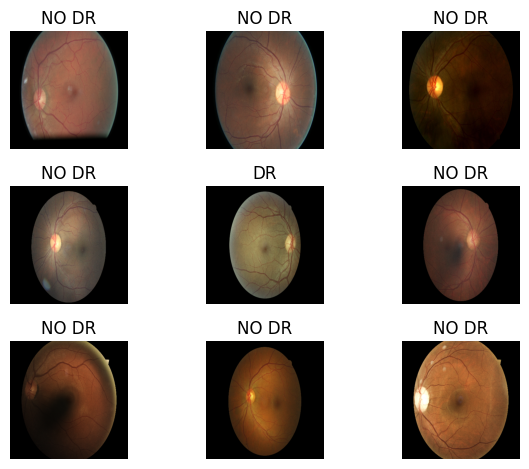

In [264]:
mostrar_grafica(n_col=3, n_ren=3, list_image=imagenes_retina)

#### PREPROCESAMIENTO

In [265]:
def ajuste_brillo_contraste(image):
    mean, stddev = cv2.meanStdDev(image)

    hist = image.flatten()
    mediana = np.percentile(hist, 50)
    ax = 128 - mediana 

    epsilon = 1e-6  

    alpha = 100 / (stddev[0][0] + epsilon)
    alpha = np.clip(alpha, 0.8, 2.5)

    beta = ax - mean[0][0]
    beta = np.clip(beta, -50, 50)

    adjusted = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

    return adjusted

In [266]:
# def ajuste_brillo_contraste(image):
#     mean, stddev = cv2.meanStdDev(image)

#     #alpha = 100 / stddev[0][0] 
#     #beta = 65 - mean[0][0]

#     alpha = 80 / stddev[0][0] 
#     beta = 50 - mean[0][0]

#     #print(alpha,beta)
#     # c = 1.0
#     # b = 10
    
#     adjusted = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    
#     #adjusted = cv2.normalize(image, None, alpha=0, beta=200, norm_type=cv2.NORM_MINMAX)

#     return adjusted

In [267]:
def clip_limit_adaptativo(image, base_clip=2.0, scale_factor=5.0, min_limit=0.5, max_limit=3.0):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    std_dev = np.std(gray_image)
    
    normalized_std = std_dev / 255  
    clip_limit = base_clip + (normalized_std * scale_factor)

    return np.clip(clip_limit, min_limit, max_limit)

In [268]:
# def clip_limit_adaptativo(image, base_clip=2.0, scale_factor= 5.0):
#     gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     std_dev = np.std(gray_image)
#     clip_limit = base_clip + (std_dev / 255) * scale_factor
#     return max(clip_limit, 0.1)

In [269]:
def clahe_funcion(image):
    clip_limit_value = clip_limit_adaptativo(image)

    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    lab_planes = list(cv2.split(lab))

    #print(clip_limit_value)
    clahe = cv2.createCLAHE(clipLimit=clip_limit_value,tileGridSize=(8,8))
    lab_planes[0] = clahe.apply(lab_planes[0])
    lab = cv2.merge(lab_planes)
    bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

    return bgr

In [270]:
def recorte_Bordes(img_sinReco):
    gray_image = cv2.cvtColor(img_sinReco, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray_image, 10, 255, cv2.THRESH_BINARY)
    contorno, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contorno:
        return cv2.resize(img_sinReco, (400, 400))

    cont = max(contorno, key=cv2.contourArea)
    
    x, y, w, h = cv2.boundingRect(cont)
    Imag_recort = img_sinReco[y:y+h, x:x+w]
    Imag_recort = cv2.resize(Imag_recort,(400,400))
    
    return Imag_recort

In [271]:
def auto_gammaCorrection(image):
    image_Gamma = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hue, sat, val = cv2.split(image_Gamma)


    mid = 0.5
    mean = np.mean(val)
    meanlog = math.log(mean)
    midlog = math.log(mid*255)
    gamma = midlog/meanlog
    gamma = 1 / gamma

    table = np.array([((i / 255.0) ** gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

In [272]:
# def auto_gamma_correction(image, alpha=0.5, beta=1.5):
#     brightness = np.mean(image)

#     brightness_norm = brightness / 255.0

#     # Invertir relación: imágenes más oscuras -> gamma mayor
#     gamma = beta - (beta - alpha) * brightness_norm


#     inv_gamma = 1.0 / gamma
#     table = np.array([(i / 255.0) ** inv_gamma * 255 for i in range(256)]).astype("uint8")
#     corrected_image = cv2.LUT(image, table)

#     return corrected_image

In [273]:
def apply_wavelet_enhancement(channel, wavelet='db4', level=3, factors=(1.5, 1.5, 2.0)):
    coeffs = pywt.wavedec2(channel, wavelet, level=level)
    coeffs_H = list(coeffs)

    # Realzar las subbandas LH, HL, HH en cada nivel
    for i in range(1, len(coeffs_H)):
        cH, cV, cD = coeffs_H[i]
        coeffs_H[i] = (
            cH * factors[0],  # Horizontal
            cV * factors[1],  # Vertical
            cD * factors[2],  # Diagonal
        )

    enhanced_channel = pywt.waverec2(coeffs_H, wavelet)
    enhanced_channel = np.clip(enhanced_channel, 0, 255)
    return np.uint8(enhanced_channel)


In [274]:
# def apply_wavelet_enhancement(channel, wavelet='db4', level=3, factor=2):
#     coeffs = pywt.wavedec2(channel, wavelet, level=level)
#     coeffs_H = list(coeffs)
    
#     # Aumentar la magnitud de los coeficientes de detalle para realzar bordes
#     for i in range(1, len(coeffs_H)):  # Evitar el coeficiente de aproximación
#         coeffs_H[i] = tuple(c * factor for c in coeffs_H[i])
    
#     # Reconstrucción del canal
#     enhanced_channel = pywt.waverec2(coeffs_H, wavelet)
    
#     enhanced_channel = np.clip(enhanced_channel, 0, 255)
#     return np.uint8(enhanced_channel)

In [275]:
def wavelet(imagen):
    R, G, B = cv2.split(imagen)
    R_enhanced = apply_wavelet_enhancement(R)
    G_enhanced = apply_wavelet_enhancement(G)
    B_enhanced = apply_wavelet_enhancement(B)
    
    return cv2.merge((R_enhanced, G_enhanced, B_enhanced))

In [276]:
def filtrado_bilateral(image):
    return cv2.bilateralFilter(image,9,6,6)

In [277]:
def reduccion_ruido(image):
    return cv2.fastNlMeansDenoisingColored(image, h=7, templateWindowSize=8, searchWindowSize=21)

In [278]:
for index in tqdm(range(len(imagenes_retina))):
    image_aux = imagenes_retina[index]
    # image_aux = filtrado_bilateral(image_aux)
    # image_aux = recorte_Bordes(image_aux)
    
    # image_aux = ajuste_brillo_contraste(image_aux)
    # image_aux = auto_gammaCorrection(image_aux)
    # image_aux = clahe_funcion(image_aux)
    # image_aux = wavelet(image_aux)
    # image_aux = recorte_Bordes(image_aux)

    #---------

    image_aux = filtrado_bilateral(image_aux)
    image_aux = recorte_Bordes(image_aux)
    image_aux = ajuste_brillo_contraste(image_aux)
    image_aux = clahe_funcion(image_aux)
    image_aux = auto_gammaCorrection(image_aux)
    #image_aux = wavelet(image_aux)
    #image_aux = clahe_funcion(image_aux)

    #----------
    # GUARDADO DE IMAGENES
    imagenes_retina_mod[index] = image_aux

100%|██████████| 9/9 [00:00<00:00, 48.12it/s]


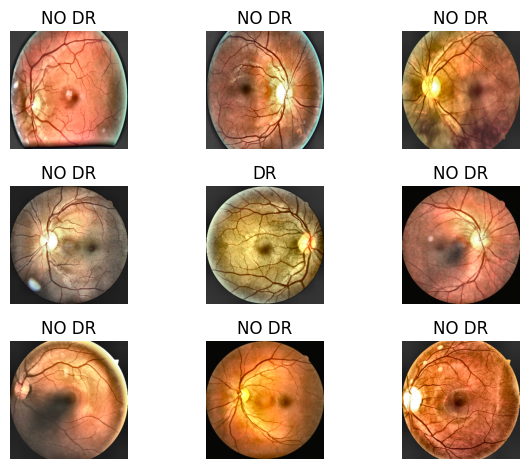

In [279]:
mostrar_grafica(n_col=3, n_ren=3, list_image=imagenes_retina_mod)

In [280]:
image = imagenes_retina[4]

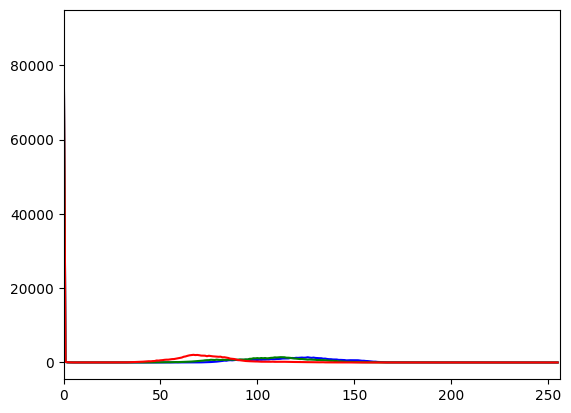

In [281]:
color = ('b','g','r')

for i, c in enumerate(color):
    hist = cv2.calcHist([image], [i], None, [256], [0, 256])
    plt.plot(hist, color = c)
    plt.xlim([0,256])

plt.show()

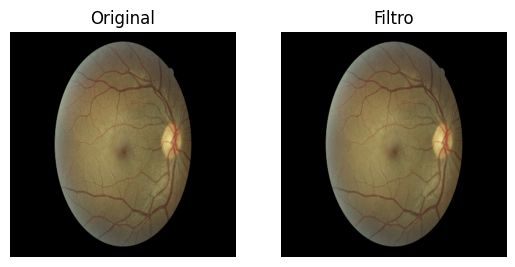

In [282]:
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(imagenes_retina[4], cmap="gray")
plt.title("Original")

image = filtrado_bilateral(imagenes_retina[4])

plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(image, cmap="gray")
plt.title("Filtro")

plt.show()

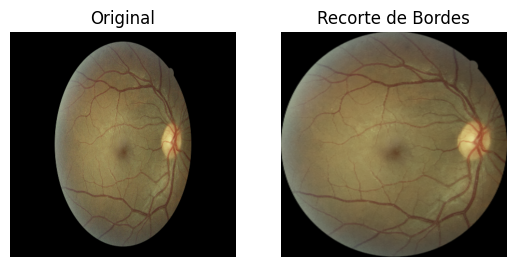

In [283]:
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(imagenes_retina[4], cmap="gray")
plt.title("Original")

image = recorte_Bordes(image)

plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(image, cmap="gray")
plt.title("Recorte de Bordes")

plt.show()

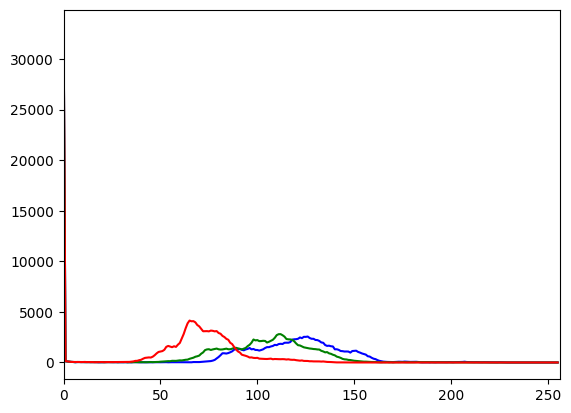

In [284]:
color = ('b','g','r')

for i, c in enumerate(color):
    hist = cv2.calcHist([image], [i], None, [256], [0, 256])
    plt.plot(hist, color = c)
    plt.xlim([0,256])

plt.show()

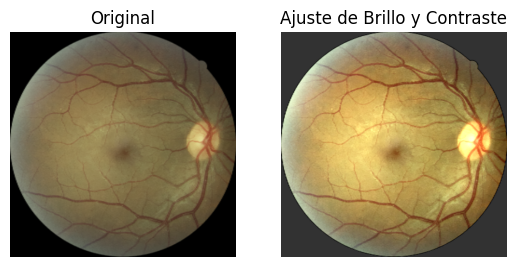

In [285]:
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(image, cmap="gray")
plt.title("Original")

image = ajuste_brillo_contraste(image)

plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(image, cmap="gray")
plt.title("Ajuste de Brillo y Contraste")

plt.show()

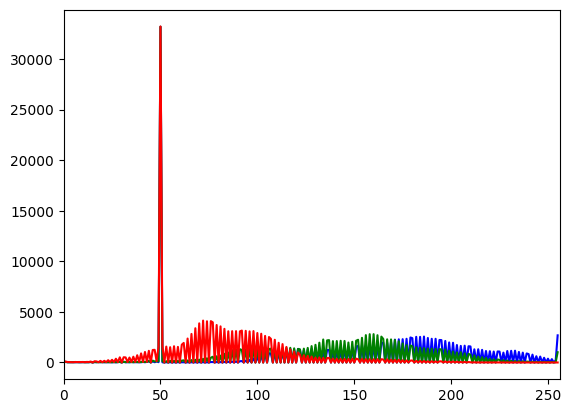

In [286]:
color = ('b','g','r')

for i, c in enumerate(color):
    hist = cv2.calcHist([image], [i], None, [256], [0, 256])
    plt.plot(hist, color = c)
    plt.xlim([0,256])

plt.show()

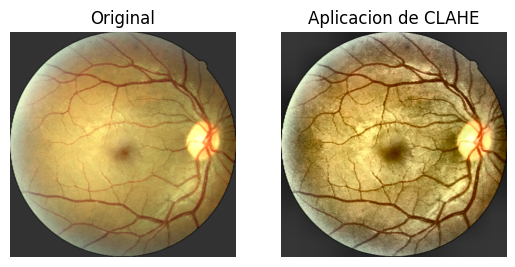

In [287]:
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(image, cmap="gray")
plt.title("Original")

image = clahe_funcion(image)

plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(image, cmap="gray")
plt.title("Aplicacion de CLAHE")

plt.show()

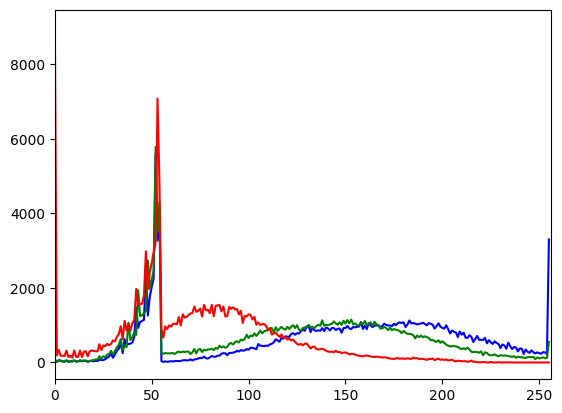

In [288]:
color = ('b','g','r')

for i, c in enumerate(color):
    hist = cv2.calcHist([image], [i], None, [256], [0, 256])
    plt.plot(hist, color = c)
    plt.xlim([0,256])

plt.show()

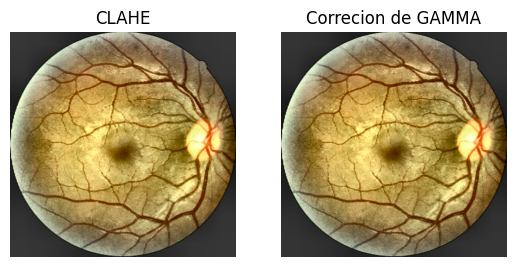

In [289]:
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(image, cmap="gray")
plt.title("CLAHE")

image = auto_gammaCorrection(image)

plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(image, cmap="gray")
plt.title("Correcion de GAMMA")

plt.show()

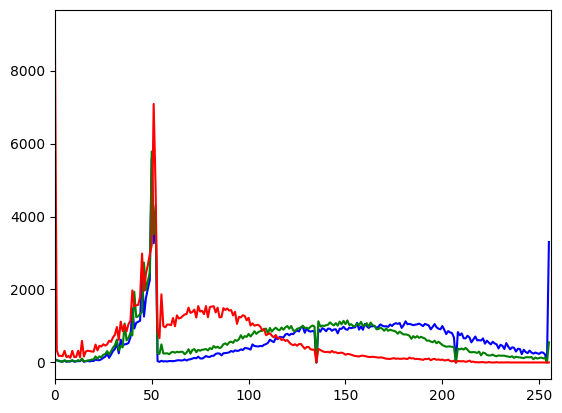

In [290]:
color = ('b','g','r')

for i, c in enumerate(color):
    hist = cv2.calcHist([image], [i], None, [256], [0, 256])
    plt.plot(hist, color = c)
    plt.xlim([0,256])

plt.show()

### CAMBIOS

In [292]:
# def recorte_Bordes(img_sinReco):
#     gray_image = cv2.cvtColor(img_sinReco, cv2.COLOR_BGR2GRAY)
#     _, thresh = cv2.threshold(gray_image, 5, 255, cv2.THRESH_BINARY)
    

#     plt.axis("off")
#     plt.imshow(thresh)

#     contorno, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
#     if not contorno:
#         return cv2.resize(img_sinReco, (400, 400))

#     cont = max(contorno, key=cv2.contourArea)
    
#     x, y, w, h = cv2.boundingRect(cont)
#     Imag_recort = img_sinReco[y:y+h, x:x+w]
#     Imag_recort = cv2.resize(Imag_recort,(400,400))
    
#     return Imag_recort

In [293]:
# color = ('b','g','r')

# for i, c in enumerate(color):
#     hist = cv2.calcHist([image], [i], None, [256], [0, 256])
#     plt.plot(hist, color = c)
#     plt.xlim([0,256])

# plt.show()